# Relationships

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

## Correlation

In [Notebook 9](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/master/09_relationships.ipynb), I suggest that using correlation to summarize the relationship between two variables is problematic:

1. Correlation only quantifies the linear relationship between variables; if the relationship is non-linear, correlation tends to underestimate it.

2. Correlation quantifies predictability, but not the "strength" of the relationship in terms of slope.  In practice, slope is often more important.

In this notebook I explore two more reasons correlation is not a great statistic: 

3. It is hard to interpret as a measure of predictability.

4. It makes the relationship between variables sound more impressive than it is.

As an example, I quantify the relationship between SAT scores and IQ tests.  I know this is a contentious topic; people have strong feelings about standardized tests, IQ, and the consequences of using standardized tests for college admissions.

I chose this example because it is a topic people care about, and I think the analysis I present can contribute to the discussion.

But a similar analysis applies in any domain where we use a correlation to quantify the strength of a relationship between two variables.

## SAT scores and IQ

According to Frey and Detterman, "[Scholastic Assessment or g? The relationship between the Scholastic Assessment Test and general cognitive ability](https://www.ncbi.nlm.nih.gov/pubmed/15147489)", the correlation between SAT scores and general intelligence ($G$) is 0.82.

This is just one study, and if you read the paper, you might have questions about the methodology.  But for now I will take this estimate at face value.  If you have another source that reports a different correlation, feel free to plug in another value and run my analysis again.

For concreteness, I will generate a fake dataset that has the same mean and standard deviation as the SAT and the IQ, with a correlation of 0.82.

According to [this source](https://blog.prepscholar.com/sat-standard-deviation), the mean combined SAT score is 1060 with standard deviation 210.

Here's a sample from a normal distribution with these parameters:

In [2]:
import numpy as np
np.random.seed(17)

In [3]:
mean_sat = 1060
sigma1 = 210

sat = np.random.normal(mean_sat, sigma1, size=1000)

And here's what the distribution looks like.

In [4]:
from empiricaldist import Cdf
import matplotlib.pyplot as plt

Cdf.from_seq(sat).plot()

plt.xlabel('SAT Score')
plt.ylabel('CDF')
plt.title('Distribution of SAT Scores');

By design, IQ has mean 100 and standard deviation 15:

In [5]:
mean_iq = 100
sigma2 = 15

Here's a process for generating a sample of IQs with the given mean, standard deviation, and correlation with SAT scores:

In [6]:
rho = 0.82
mus = mean_iq + rho * sigma2 / sigma1 * (sat - mean_sat)
var = (1 - rho**2) * sigma2**2
sigma = np.sqrt(var)

iq = np.random.normal(mus, sigma)

Here's what the distribution looks like.

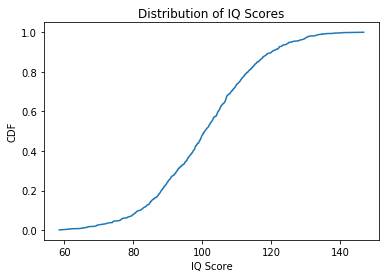

In [7]:
Cdf.from_seq(iq).plot()

plt.xlabel('IQ Score')
plt.ylabel('CDF')
plt.title('Distribution of IQ Scores');

The mean and standard deviation are near 100 and 15, as desired.

In [8]:
iq.mean(), iq.std()

(100.83545751444824, 14.972752039618916)

And the correlation is near 0.82.

In [9]:
a = np.corrcoef(sat, iq)
rho_actual = a[0, 1]
rho_actual

0.8149920921319724

This scatterplot shows the relationship between IQ and SAT in my simulated dataset.

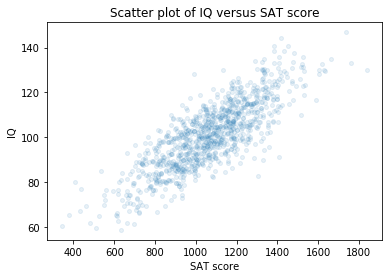

In [10]:
plt.plot(sat, iq, 'o', alpha=0.1, markersize=4)

plt.xlabel('SAT score')
plt.ylabel('IQ')
plt.title('Scatter plot of IQ versus SAT score');

## Linear regression

We can use SciPy to estimate the slope and intercept of the linear regression line.

In [11]:
from scipy.stats import linregress

res = linregress(sat, iq)
res

LinregressResult(slope=0.05705580427705706, intercept=40.09937233352963, rvalue=0.8149920921319724, pvalue=9.939004643996963e-239, stderr=0.0012841438637785235)

The result includes `intercept` and `slope`, which we can use to compute the predicted IQ for each SAT score in the sample.

In [12]:
pred_iq = res.intercept + res.slope * sat

Here's the scatter plot again with the regression line.

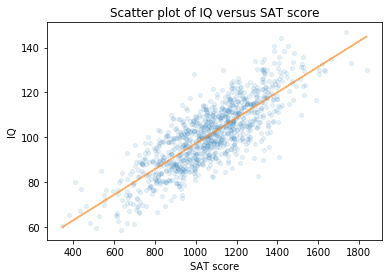

In [13]:
plt.plot(sat, iq, 'o', alpha=0.1, markersize=4)
plt.plot(sat, pred_iq, alpha=0.6)

plt.xlabel('SAT score')
plt.ylabel('IQ')
plt.title('Scatter plot of IQ versus SAT score');

## Residuals

Now we can compute the residuals, which are the errors for each prediction.

In [14]:
resid = iq - pred_iq

We can use the residuals to compute the coefficient of determination, $R^2$.

In [15]:
R2 = 1 - resid.var() / iq.var()
R2

0.6642121102376496

$R^2$ measures the part of the variance in the dependent variable (IQ) that is "explained by" the predictor (SAT score).

Or, to say that differently, if we use SAT scores to guess IQs, the variance of the errors will be 66% lower than the variance in IQ scores.

That sounds less impressive than a correlation of 0.82.  And that's because there is a relationship between correlation and the coefficient of determination:

$R^2 = \rho^2$

That is, the coefficient of determination is correlation squared.  We can confirm that this equation holds in this example:

In [16]:
R2, rho_actual**2

(0.6642121102376496, 0.6642121102376495)

Since correlation is less than 1, $R^2$ is generally smaller than $\rho$.

In [17]:
R2, rho_actual

(0.6642121102376496, 0.8149920921319724)

If you have a choice of reporting $R^2$ or correlation, I suggest you report $R^2$ because it is more meaningful (percentage reduction in variance) and less falsely impressive.

However, I think $R^2$ is also problematic, because reducing variance is not usually what we care about.

If the goal is to quantify the quality of a prediction, it is better to use a metric of error that means something in the context of the problem. 

## MAE

One option is mean absolute error (MAE) which is just what it says: the mean of the absolute values of the residuals.

In [18]:
MAE_after = np.abs(resid).std()
MAE_after

5.087265273780449

If you use someone's SAT score to guess their IQ, you should expect to be off by about 5 points on average.

One way to put that in context is to compare it to the MAE if we don't know SAT scores.  

In that case, the best strategy is to guess the mean every time.

In [19]:
deviation = iq - iq.mean()
MAE_before = np.abs(deviation).std()
MAE_before

9.073694780207806

If you always guess 100, you should expect to be off by about 8.5 points on average.

We can use these results to compute the percentage improvement in MAE, with and without SAT scores:

In [20]:
improvement = 1 - MAE_after / MAE_before
improvement

0.4393391670086636

So we can say that knowing SAT scores us decreases the MAE by 44%.

That is certainly an improvement, but notice that it sounds less impressive than $R^2 = 0.66$ and much less impressive than $\rho = 0.82$.

## RMSE

Another option is RMSE (root mean squared error) which is the standard deviation of the residuals:

In [21]:
RMSE_after = resid.std()
RMSE_after

8.67629174527911

We can compare that to RMSE without SAT scores, which is the standard deviation of IQ:

In [22]:
RMSE_before = iq.std()
RMSE_before

14.972752039618916

And here's the improvement:

In [23]:
improvement = 1 - RMSE_after / RMSE_before
improvement

0.4205279214989299

If you know someone's SAT score, you can decrease your RMSE by 42%.

There is no compelling reason to prefer RMSE over MAE, but it has practical one advantage: we don't need the data to compute the RMSE.  We can derive it from the variance of IQ and $R^2$:

$R^2 = 1 - Var(resid) ~/~ Var(iq)$

$Var(resid) = (1 - R^2)~Var(iq)$

$Std(resid) = \sqrt{(1 - R^2) Var(iq)}$

In [24]:
np.sqrt((1-R2) * iq.var()), RMSE_after

(8.67629174527911, 8.67629174527911)

## Percentage error

One other way to express the value of SAT scores for predicting IQ is the mean absolute percentage error (MAPE).

Again, if we don't know SAT scores, the best strategy is to guess the mean.  In that case the MAPE is:

In [25]:
deviation = iq - iq.mean()
MAPE_before = np.abs(deviation / iq).mean() * 100
MAPE_before

12.391059933375567

If we always guess the mean, we expect to be off by 12%, on average.

If we use SAT scores to make better guesses, the MAPE is lower:

In [26]:
MAPE_after = np.abs(resid / iq).mean() * 100
MAPE_after

7.167931974380457

So we expect to be off by 6.6% on average.

And we can quantify the improvement like this:

In [27]:
improvement = 1 - MAPE_after / MAPE_before
improvement

0.4215239040952834

Using SAT scores to predict IQ decreases the mean absolute percentage error by 42%.

I included MAPE in this discussion because it is a good choice in some contexts, but this is probably not one of them.

Using MAPE implies that an error of 1 IQ point is more important for someone with low IQ and less important for someone with high IQ.  In this context, it's not clear whether that's true.

## Correlation overstates usefulness

In this example, we've looked at one value of correlation, 0.82.

We can do the same analysis for a range of values:

In [28]:
rhos = np.linspace(0, 1, 201)
R2s = rhos**2
improvements = 1 - np.sqrt(1-R2s)

And here's what it looks like:

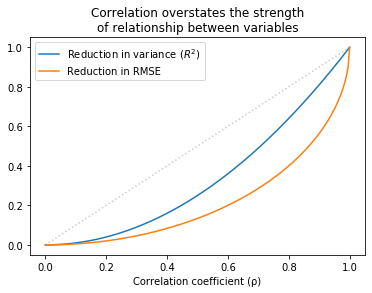

In [29]:
plt.plot(rhos, rhos, linestyle='dotted', color='gray', alpha=0.4)
plt.plot(rhos, R2s, label='Reduction in variance ($R^2$)')
plt.plot(rhos, improvements, label='Reduction in RMSE')

plt.xlabel('Correlation coefficient (ρ)')
plt.title('Correlation overstates the strength\nof relationship between variables')

plt.legend();

For all values except 0 and 1, $R^2$ is less than correlation, $\rho$.

And the improvement in RMSE is less than that.

## Summary

Correlation is a problematic statistic because it sounds more impressive than it is.

Coefficient of determination, $R^2$ is better because it has a more natural interpretation: percentage reduction in variance.  But reducing variance it usually not what we care about.

I think it is better to choose a measurement of error that is meaningful in context, possibly one of:

* MAE: Mean absolute error

* RMSE: Root mean squared error

* MAPE: Mean absolute percentage error

Which one of these is most meaningful depends on the cost function.  Does the cost of being wrong depend on the absolute error, squared error, or percentage error?  If so, that should guide your choice.

One advantage of RMSE is that we don't need the data to compute it; we only need the variance of the dependent variable and either $\rho$ or $R^2$.

In this example, the correlation is 0.82, which sounds much more impressive than it is.

$R^2$ is 0.66, which means we can reduce variance by 66%.  But that also sounds more impressive than it is.

Using SAT scores to predict IQ, we can reduce MAE by 44%; we can reduce MAPE by 42%, and we can reduce MAPE by 42%.

Reporting any of these is more meaningful than reporting correlation or $R^2$.